In [9]:
import import_src
from pybroker.order_broker import Broker
from pybroker.event_publisher import EventPublisher
from pybroker.broker_vis import *
from pybroker.models import *
from pybroker.agents import *
import numpy as np
import random
import pandas as pd
from datetime import datetime
from IPython.display import clear_output

In [10]:
event_publisher = EventPublisher()

# Create a broker, and a market for ACME stock
asset = "ACME"
broker = Broker(event_publisher)
broker.create_market(asset)

In [11]:
trader_initial_cash = 10000
trader_initial_assets = {asset: trader_initial_cash // 320}
num_smart_traders = 10
num_random_traders = 50
num_steps = 100000


smartTraderIds = set([i + 1000 for i in range(num_smart_traders)])

# create an agent breeder
breeder = AgentBreeder(
    agent_cls=FeedForwardNeuralNetwork,
    traderIds=smartTraderIds,
    broker=broker,

    breeder_cash_balance=trader_initial_cash * len(smartTraderIds),
    breeder_asset_balances={asset: trader_initial_assets[asset] * len(smartTraderIds)},
)

# Add market participants with random behaviour for liquidity
randomTraders:dict[int, Agent] = {}
for i in range(num_random_traders):
    traderId = i
    if i % 25 == 0:
        randomTrader = RandomMonkey()
    else:
        randomTrader = RandomTrendFollower()

    randomTraders[traderId] = randomTrader
    broker.open_account(traderId)
    broker.deposit_cash(traderId, trader_initial_cash)
    for asset, amount in trader_initial_assets.items():
        broker.deposit_asset(traderId, amount, asset)


Step 22999/100000


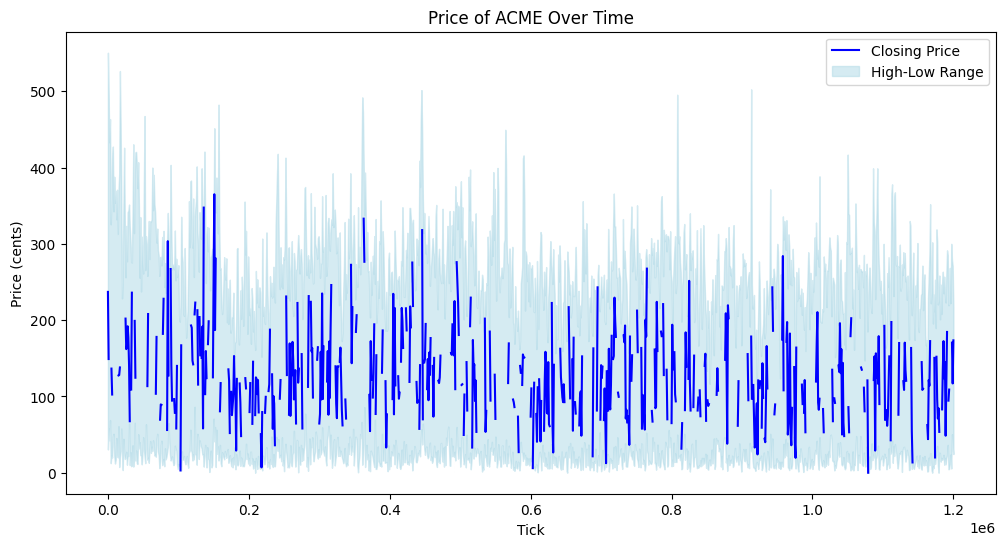

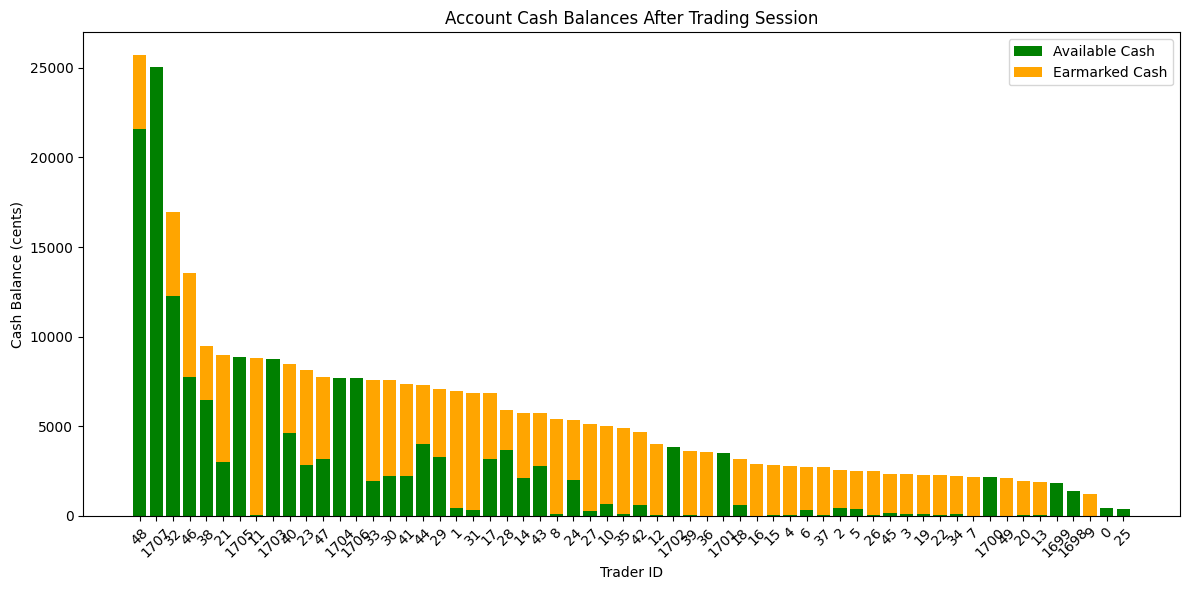

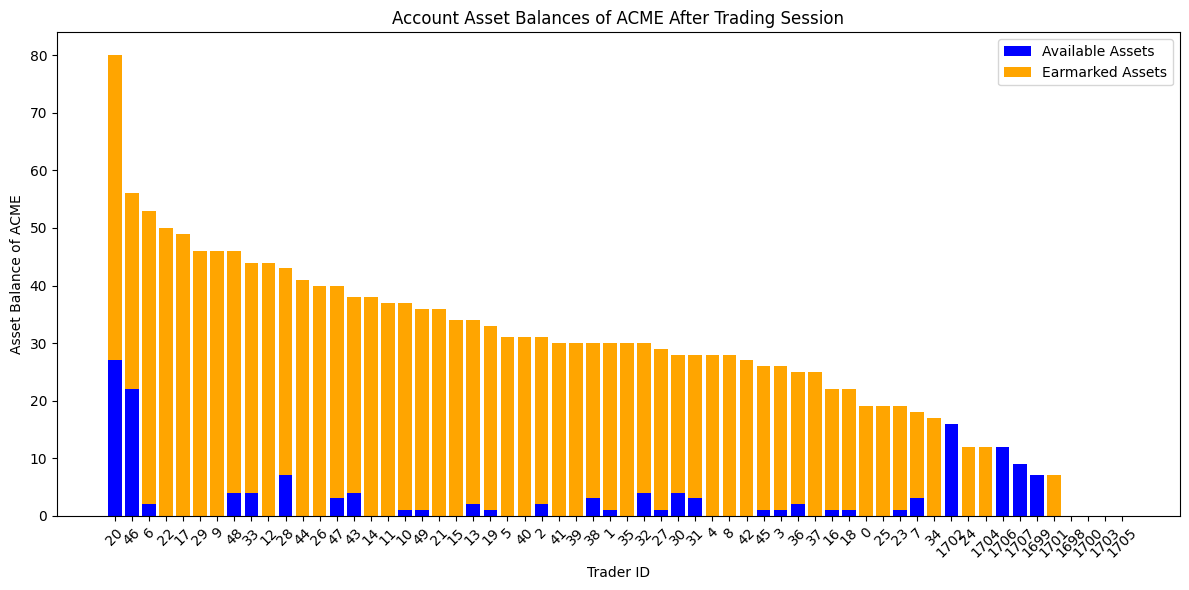

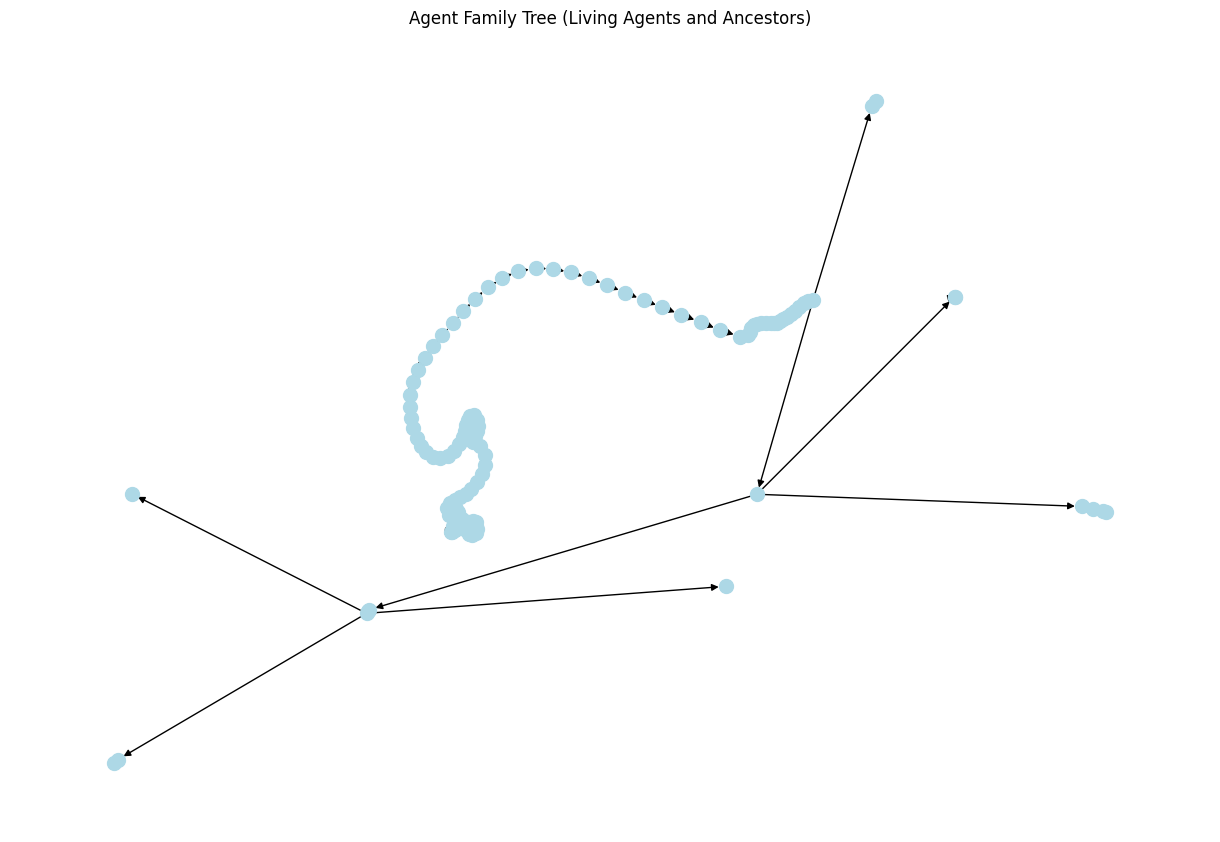

Invalid Order!
Traceback (most recent call last):
  File "/Users/jacobstahl/Desktop/Code/PythonOrderBroker/pybroker/order_broker.py", line 169, in place_order
    assert order.priceCents >= 0
           ^^^^^^^^^^^^^^^^^^^^^
AssertionError
Invalid Order!
Traceback (most recent call last):
  File "/Users/jacobstahl/Desktop/Code/PythonOrderBroker/pybroker/order_broker.py", line 169, in place_order
    assert order.priceCents >= 0
           ^^^^^^^^^^^^^^^^^^^^^
AssertionError
Invalid Order!
Traceback (most recent call last):
  File "/Users/jacobstahl/Desktop/Code/PythonOrderBroker/pybroker/order_broker.py", line 169, in place_order
    assert order.priceCents >= 0
           ^^^^^^^^^^^^^^^^^^^^^
AssertionError
Invalid Order!
Traceback (most recent call last):
  File "/Users/jacobstahl/Desktop/Code/PythonOrderBroker/pybroker/order_broker.py", line 169, in place_order
    assert order.priceCents >= 0
           ^^^^^^^^^^^^^^^^^^^^^
AssertionError
Invalid Order!
Traceback (most recent ca

In [ ]:
# run training
for step in range(num_steps):

    # let random traders act
    for traderId, randomTrader in randomTraders.items():
        for asset in trader_initial_assets.keys():
            observations = observe(broker, traderId, asset)
            actions = randomTrader.policy(observations)
            for order in actions.orders:
                broker.place_order(asset, order)

    # let breeder agents act
    breeder.step(broker)
    if (step + 1) % 1000 == 0:
        clear_output(wait=True)
        print(f"Step {step}/{num_steps}")
        show_price_over_time(broker, asset)
        show_account_cash_balances(broker)
        show_account_asset_balances(broker, asset)
        show_family_tree(breeder)

    # End trading day after N steps, reseting order books
    if (step + 1) % 100 == 0:
        broker.end_trading_day()